In [1]:
%matplotlib inline
# from ExKMC.Tree import Tree # import from cloned local library followed by installing manually
import sys
sys.path.append('../')
from ExKMC_M.ExKMC.Tree import Tree

from sklearn.datasets import make_blobs
import gdown
import pandas as pd
import copy
from sklearn.cluster import KMeans
from utils import calc_cost, plot_kmeans, plot_tree_boundary,plot_confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, normalize
from utils import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils import check_random_state, check_X_y, _safe_indexing
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_chunked
from sklearn.preprocessing import LabelEncoder
import functools
from sklearn.feature_selection import SelectKBest, mutual_info_regression,mutual_info_classif

from sklearn.decomposition import PCA,SparsePCA


In [2]:
# print(os.path.join(os.path.dirname(__file__),"./data/negtive.csv"))
# print(os.path.join(os.path.abspath('algorithms/Kmeans+.ipynb'),"./data/negtive.csv"))
# print(os.path.abspath('algorithms/Kmeans+.ipynb'))


## data preprocessing

In [2]:
# input data
def getDataDrive(url, output, isImport=False):
    """
    return pandas dataframe
    """
    if isImport:
        gdown.download(url=url, output=output, quiet=False)
    res = pd.read_csv(output)
    return res


neg = getDataDrive(
    url="https://drive.google.com/uc?id=1ocidTn7jUvCrLG_XJ6H9MiNUDexCkjFG",
    output="/home/sfy/Documents/VScodeProject/Thesis/data/negtive.csv",
)
pos = getDataDrive(
    url="https://drive.google.com/uc?id=1IyMPjACBkz96giGJ-Z4IMk-qzM-1CJ9G",
    output="/home/sfy/Documents/VScodeProject/Thesis/data/positive.csv",
)

X_neg = copy.deepcopy(neg)
X_pos = copy.deepcopy(pos)


In [3]:
pos_target = [0 for _ in range(X_pos.shape[0])]
neg_target = [1 for _ in range(X_neg.shape[0])]

X_pos["y"] = pos_target
X_neg["y"] = neg_target

X__ = pd.concat([X_pos, X_neg])

# exclue name -> X_
X_ = X__.loc[:, X__.columns != "name"]

# exclude label -> X
y = X_["y"]
X = X_.loc[:, X_.columns != "y"]

# data preprocess
# Standardize data
# TODO train_test_split(X, y, test_size=0.4, random_state=0)


#output X_
# X_.to_csv('alldata.csv',index=False)


In [48]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

# selector = SelectKBest(mutual_info_regression, k = 120)
# selector.fit(X_train, y_train)
# X_train.columns[selector.get_support()]

# X_train = X_train.iloc[:,X_train.columns[selector.get_support()]]

# X_train.shape

(12377, 120)

## Algorithm

In [4]:
################################ kmeans
k = 2
# random = KMeans(k,random_state=0)
# ran_labels = random.fit_predict(train_data)

def run2algs(train_data,leaves,k):
    kmeans = KMeans(n_clusters= k)
    cluster_labels = kmeans.fit_predict(train_data)

    ################################ tree
    tree = Tree(k=k,max_leaves=leaves)
    tree_labels = tree.fit_predict(train_data, kmeans)

    return kmeans,cluster_labels,tree_labels


## evaluation

### fscore and accuracy

In [5]:
def f_a_score(true_labels,kmenas_labels,tree_labels):
    from sklearn.metrics import f1_score,accuracy_score
    print(f'fsocre of kmenas is {f1_score(y_true=true_labels,y_pred=kmenas_labels)}')
    print(f'fsocre of tree score is {f1_score(y_true=true_labels,y_pred=tree_labels)}')

    print(f'accuracy of kmenas is {accuracy_score(y_true=true_labels,y_pred=kmenas_labels)}')
    print(f'accuracy of tree score is {accuracy_score(y_true=true_labels,y_pred=tree_labels)}')


In [32]:
# X_train = PCA(n_components=20).fit_transform(X)
X_train = SparsePCA(n_components=20).fit_transform(X)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)

# Normalizing the Data
normalized_df = normalize(scaled_df)

#Converting the numpy array into a pandas DataFrame
X_train = pd.DataFrame(normalized_df)


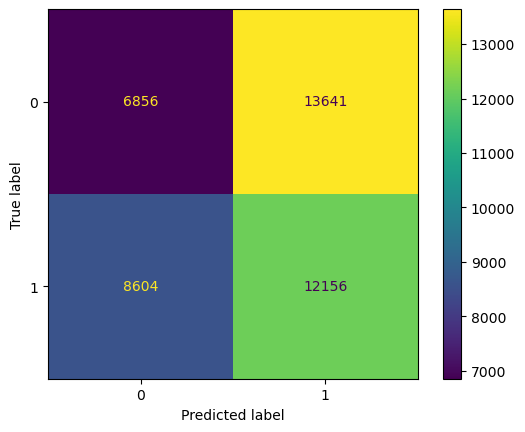

fsocre of kmenas is 0.5221985952703138
fsocre of tree score is 0.5408110296713108
accuracy of kmenas is 0.4608187701480961
accuracy of tree score is 0.46396975058777906


In [31]:
kmeans,kmeans_labels,tree_labels = run2algs(X_train,leaves=8*k,k=2)

cm = confusion_matrix(y,kmeans_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

f_a_score(y,kmeans_labels, tree_labels=tree_labels)

In [9]:
kmeans,kmeans_labels,tree_labels = run2algs(X,leaves=8*k)
f_a_score(y,kmeans_labels, tree_labels=tree_labels)

fsocre of kmenas is 0.49752173348903594
fsocre of tree score is 0.49954788539540645
accuracy of kmenas is 0.53067358266476
accuracy of tree score is 0.5304796761761641


In [10]:
from sklearn import metrics


In [11]:
metrics.fowlkes_mallows_score(y,tree_labels)

0.5060352996956079

In [12]:
metrics.silhouette_score(X,tree_labels,metric='euclidean')

0.08163651564079144

In [111]:
# test with random

f_a_score(ran_labels,tree_labels = Tree(k).fit_predict(X,random))

fsocre of kmenas is 0.5051308711179422
fsocre of tree score is 0.5307182751006624
accuracy of kmenas is 0.46932641733524005
accuracy of tree score is 0.4745618925273287


In [ ]:


def _silhouette_reduce(D_chunk, start, labels, label_freqs):
    """Accumulate silhouette statistics for vertical chunk of X.

    Parameters
    ----------
    D_chunk : array-like of shape (n_chunk_samples, n_samples)
        Precomputed distances for a chunk.
    start : int
        First index in the chunk.
    labels : array-like of shape (n_samples,)
        Corresponding cluster labels, encoded as {0, ..., n_clusters-1}.
    label_freqs : array-like
        Distribution of cluster labels in ``labels``.
    """
    # accumulate distances from each sample to each cluster
    clust_dists = np.zeros((len(D_chunk), len(label_freqs)), dtype=D_chunk.dtype)
    for i in range(len(D_chunk)):
        clust_dists[i] += np.bincount(
            labels, weights=D_chunk[i], minlength=len(label_freqs)
        )

    # intra_index selects intra-cluster distances within clust_dists
    intra_index = (np.arange(len(D_chunk)), labels[start : start + len(D_chunk)])
    # intra_clust_dists are averaged over cluster size outside this function
    intra_clust_dists = clust_dists[intra_index]
    # of the remaining distances we normalise and extract the minimum
    clust_dists[intra_index] = np.inf
    clust_dists /= label_freqs
    inter_clust_dists = clust_dists.min(axis=1)
    return intra_clust_dists, inter_clust_dists


def silhouette_score(
    X, labels, *, metric="euclidean", sample_size=None, random_state=None, **kwds
):
    if sample_size is not None:
        X, labels = check_X_y(X, labels, accept_sparse=["csc", "csr"])
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X.shape[0])[:sample_size]
        if metric == "precomputed":
            X, labels = X[indices].T[indices].T, labels[indices]
        else:
            X, labels = X[indices], labels[indices]
    else:
        scores = silhouette_samples(X, labels, metric=metric, **kwds)
    return np.mean(scores,axis=1)


def silhouette_samples(X, labels, *, metric="euclidean", **kwds):
    """Compute the Silhouette Coefficient for each sample.

    The Silhouette Coefficient is a measure of how well samples are clustered
    with samples that are similar to themselves. Clustering models with a high
    Silhouette Coefficient are said to be dense, where samples in the same
    cluster are similar to each other, and well separated, where samples in
    different clusters are not very similar to each other.

    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (``a``) and the mean nearest-cluster distance (``b``) for each
    sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
    b)``.
    Note that Silhouette Coefficient is only defined if number of labels
    is 2 ``<= n_labels <= n_samples - 1``.

    This function returns the Silhouette Coefficient for each sample.

    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters.
    """
    X, labels = check_X_y(X, labels, accept_sparse=["csc", "csr"])

    # Check for non-zero diagonal entries in precomputed distance matrix
    if metric == "precomputed":
        error_msg = ValueError(
            "The precomputed distance matrix contains non-zero "
            "elements on the diagonal. Use np.fill_diagonal(X, 0)."
        )
        if X.dtype.kind == "f":
            atol = np.finfo(X.dtype).eps * 100
            if np.any(np.abs(np.diagonal(X)) > atol):
                raise ValueError(error_msg)
        elif np.any(np.diagonal(X) != 0):  # integral dtype
            raise ValueError(error_msg)

    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples = len(labels)
    label_freqs = np.bincount(labels)

    kwds["metric"] = metric
    reduce_func = functools.partial(
        _silhouette_reduce, labels=labels, label_freqs=label_freqs
    )
    results = zip(*pairwise_distances_chunked(X, reduce_func=reduce_func, **kwds))
    intra_clust_dists, inter_clust_dists = results
    # intra:35655.59,inter:1.559
    intra_clust_dists = np.concatenate(intra_clust_dists)
    inter_clust_dists = np.concatenate(inter_clust_dists)
# unknow operatino of denom # after denom the dists become 1.49 before is 30234
    denom = (label_freqs - 1).take(labels, mode="clip")
    with np.errstate(divide="ignore", invalid="ignore"):
        intra_clust_dists /= denom

    sil_samples = inter_clust_dists - intra_clust_dists
    with np.errstate(divide="ignore", invalid="ignore"):
        sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # nan values are for clusters of size 1, and should be 0
    return [intra_clust_dists,inter_clust_dists,np.nan_to_num(sil_samples)]


# print(f'intra and inter distance of kmenas is {silhouette_score(X=X_train, labels=kmeans_labels)}')
# print(f'intra and inter distance of tree score is {silhouette_score(X=X_train, labels=tree_labels)}')


In [ ]:
# cost
# kmeas cost in paper: The k-means cost is the sum of squared distances of each point to the mean of points associated with the cluster.
# kmenas cost in sklearn:Opposite of the value of X on the K-means objective.
# surrogate cost:The k-means surrogate cost is the sum of squared distances of each point to the closest center of the kmeans given (or trained) in the fit method.k-means surrogate cost > k-means cost, as k-means cost is computed with respect to the optimal centers.

kmeas_cost = tree.score(X_train)
surrogate_score = tree.surrogate_score(X_train)
print(
    f"kmeans_cost is {kmeas_cost} \nsurrogate_score is {surrogate_score}\nkmenas cost in surrogate is {kmeans.score(X_train)}"
)

#test with distancs munally
# inter-distance
from scipy.spatial.distance import euclidean

dst = euclidean(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1])
print(f"inter distance from kmeans:{dst}")

tree_centers = tree.get_centers()
tree_dst = euclidean(tree_centers[0], tree_centers[1])
print(f"inter distance from tree:{tree_dst}")